# Quantum Monte Carlo on Quantum Computers

In the previous notebook, we have extensively discussed the motivation for incorporating quantum computing into the classical QMC algorithms for better accuracy. And we have also explored using vacuum reference circuits to evaluate $\langle\Psi_T|\phi\rangle, \langle\Psi_T|H|\phi\rangle$ at every timestep. In this notebook, we are going to investigate an alternative approach--classical shadows [1], to evaluate these intermediate quantities.

<div class="alert alert-block alert-info">
<b>Note:</b> The code in this notebook has option to use multiprocessing for computations. A notebook instance with multiple CPU cores is required to use multiprocessing. With a ml.m5.24xlarge notebook instance, the code takes about 6 minutes in total to run in this notebook, which will incur charge for about \$0.6 USD. The notebook also creates a Braket job to compute a scaled-up QMC workload that takes about 30 minutes with a ml.m5.24xlarge job instance, which will incur charge for about \$2.8 USD.
</div>

In [1]:
import time
import numpy as np
import pennylane as qml
from typing import Callable, List, Tuple

np.set_printoptions(precision=6, edgeitems=10, linewidth=150, suppress=True)

In [2]:
# define the ansatz circuit

def V_T():
    qml.DoubleExcitation(0.12, wires=[0,1,2,3])

In [3]:
###########################################################
# Prepare the necessary operators for AFQMC calculations. #
###########################################################

from pyscf import fci, gto, scf
from afqmc.utils.chemical_preparation import chemistry_preparation

# perform HF calculations
mol = gto.M(atom="H 0. 0. 0.; H 0. 0. 0.75", basis="sto-3g")
hf = mol.RHF()
hf.kernel()

# perform full configuration interaction (FCI) calculations
myci = fci.FCI(hf)
myci.kernel()

prop = chemistry_preparation(mol, hf)

converged SCF energy = -1.1161514489386


## Part I. Classical shadows

Estimating properties of unknown quantum states is a key objective of quantum information science and technology. As in our example case, we are seeking $\langle\Psi_T|\phi\rangle$ and $\langle\Psi_T|H|\phi\rangle$ where $|\Psi_T\rangle$ is prepared on the quantum computer. However, conventional approach like quantum state tomography [2] usually requires a substantial number of measurements. 

Classical shadow is an alternative way to efficiently (but approximately) estimate expectation values of many physical observables [1]. To estimate each expectation value within error $\epsilon$ with probability at least $1 − \delta$, it requires a number of measurements that scale logarithmically with the number of observables $M$ as
$$
N_\text{sample} = O\left(\frac{\text{log}(M/\delta)}{\epsilon^2} \max_{1<i<M} \text{Var}[\hat{o}_i]\right),
$$

where $\text{Var}[\hat{o}_i]$ represents the variance of estimator $\hat{o}_i = \text{tr}(O_i\rho)$. The shadow protocol typically involves randomized measurements (random unitary rotation $U$ and projective measurements outcome $|b\rangle$) to reconstruct the unknown quantum state

$$
\rho = \mathbb{E}_{U\sim \mathcal{D}} \left[\mathcal{M}^{-1} \left(U^\dagger|b\rangle\langle b| U\right)\right],
$$

where the random unitary $U$ is sampled from certain distribution $\mathcal{D}$, and $\mathcal{M}$ represents the quantum channel that maps $\rho$ to $U^\dagger|b\rangle\langle b|U$. For more details, check Ref. [1] and this [PennyLane demo](https://pennylane.ai/qml/demos/tutorial_classical_shadows).

One characteristic of the QC-AFQMC algorithm that makes classical shadow particularly appealling is that the quantum trial state, i.e., $|\Psi_T\rangle$ as the only quantum computing component, doesn't change during the evolution of the algorithm. Therefore, if we can re-write the overlap $\langle\Psi_T|\phi\rangle$ into the form of an expectation value of any observable, we can take advantage of the logarithmic scaling of measurements of shadow tomography. This turns out to be possible as the overlap can be re-written as
$$
\langle \Psi_T|\phi\rangle = 2 \text{tr}\left(|\phi\rangle \langle \mathbf{0}| \rho\right),
$$

where $\rho$ represents the density matrix of $\frac{1}{\sqrt{2}}\left(|\Psi_T\rangle + |\mathbf{0}\rangle\right)$. The mixed estimator of the Hamiltonian $\langle \Psi_T|H|\phi\rangle$ is slightly more complicated than the overlap. However, a direct workaround is to think of $H$ as a linear combination of $O(N^4)$ number of excitation operators, and re-express $H|\phi\rangle = \sum_j|\phi_j\rangle$. Then the estimator can be converted to $\sum_j \langle\Psi|\phi_j\rangle$. We direct the interested readers to App.B in Ref. [3] for more details. Therefore, we see that both quantities can be reformulated to fit into shadow tomography, and we can benefit from the desirable scaling of quantum resource. The other advantage of leveraging shadow tomography is to rescue the QC-AFQMC algorithm from iterative communication between quantum and classical hardware, as the collected classical shadows can be re-used for every timestep during the QMC evolution. We would like to emphasize that in post-processing the classical shadows, we have used the [Numba](https://numba.pydata.org/) package to accelerate the massive matrix operations. You might also consider using GPUs to accelerate this process, which we leave to the motivated readers.

One drawback of the classical shadow's approach for QC-AFQMC, despite significant savings in the quantum computing resources, is that it increases the classical post-processing cost from $O(N^3)$ to $O(N^{8.5})$ [3]. This limits the algorithm to only small system sizes. We note that Ref. [4,5] have proposed better classical post-processing routines that leverage algorithmic differentiation to reduce the scaling to $O(N^{5.5})$. In this tutorial, we stick to the relatively high scaling implementation proposed in Ref. [3], and leave it to the readers to explore the advanced solutions.

In [4]:
###################################################
# Construct shadow circuits for hydrogen molecule #
###################################################

from afqmc.utils.shadow import calculate_classical_shadow
from afqmc.utils.matchgate import gaussian_givens_decomposition

num_qubits = 4
dev = qml.device("lightning.qubit", wires=num_qubits, shots=100)
@qml.qnode(dev)
def hydrogen_shadow_circuit(Q):
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.DoubleExcitation(0.12, wires=[0, 1, 2, 3])
    
    gaussian_givens_decomposition(Q)
    return qml.counts()

/home/ec2-user/SageMaker/QC-QMC/afqmc/utils/matchgate.py:197: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(complex128, 2, 'C', False, aligned=True), Array(complex128, 2, 'A', False, aligned=True))
  COMP = W.conj() @ Q_tilde.T @ Q.T @ b_cov @ Q @ Q_tilde @ W.conj().T


In [5]:
%%time

shadow = calculate_classical_shadow(hydrogen_shadow_circuit, 4000, num_qubits)

CPU times: user 17.1 s, sys: 43.1 ms, total: 17.1 s
Wall time: 17.1 s


## Part II. Calculating the ground state of H$_2$

First we construct the quantum trial state $|\Psi_T\rangle$.

In [6]:
from afqmc.trial_wavefunction.quantum_ovlp import QTrial
from afqmc.qmc.quantum_shadow import cqa_afqmc

## reference
psi0 = np.array([[1,0], [0,1], [0,0], [0,0]])
Angstrom_to_Bohr = 1.88973

symbols = ["H", "H"]
geometry = np.array([[0., 0., 0.], [0., 0., 0.75*Angstrom_to_Bohr]])
hamiltonian, _ = qml.qchem.molecular_hamiltonian(symbols, geometry, charge=0, basis='sto-3g')

qtrial = QTrial(prop=prop, initial_state=[0, 1], ansatz_circuit=V_T, ifshadow=True, shadow=shadow)

In [ ]:
%%time

dtau = 0.005
num_steps = 20
num_walkers = 1440

quantum_energies = cqa_afqmc(
    num_walkers,
    num_steps,
    dtau,
    qtrial,
    hamiltonian,
    psi0,
    max_pool=48,
)

Next we perform the classical QMC calculation just for comparison.

In [12]:
%%time
from afqmc.trial_wavefunction.single_slater import SingleSlater
from afqmc.qmc.classical import classical_afqmc

dtau = 0.005
num_steps = 600
num_walkers = 1440
trial = SingleSlater(prop, psi0)

local_energies, energies = classical_afqmc(
    num_walkers,
    num_steps,
    dtau,
    trial,
    prop,
    max_pool=48,
)

CPU times: user 1.82 s, sys: 964 ms, total: 2.78 s
Wall time: 3min 31s


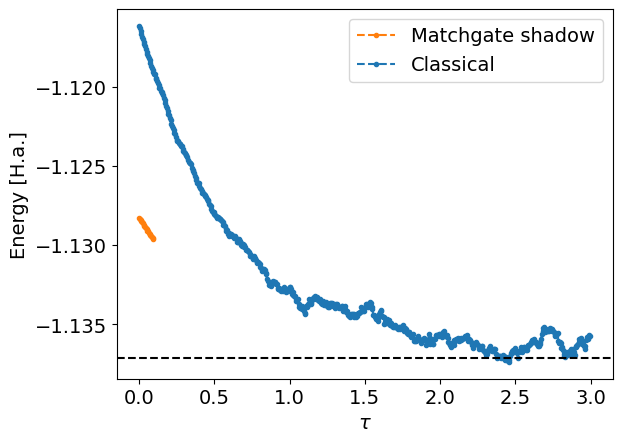

In [13]:
import matplotlib.pyplot as plt

plt.plot(
    dtau * np.arange(20),
    quantum_energies,
    linestyle="dashed",
    marker=".",
    color="tab:orange",
    label="Matchgate shadow",
)
plt.plot(
    dtau * np.arange(num_steps),
    energies,
    linestyle="dashed",
    marker=".",
    color="tab:blue",
    label="Classical",
)
plt.axhline(-1.137117067345732, linestyle="dashed", color="black")
plt.legend(fontsize=14, loc="best")
plt.xlabel(r"$\tau$", fontsize=14)
plt.ylabel("Energy [H.a.]", fontsize=14)
plt.tick_params(labelsize=14)
plt.show()

## Part III. Scaling the computation with Hybrid Jobs

In [15]:
from braket.aws import AwsQuantumJob
from braket.jobs.config import InstanceConfig

job = AwsQuantumJob.create(
    device="local:pennylane/lightning.qubit",
    source_module="afqmc",
    entry_point="afqmc.run_matchgate_shadow:run",
    job_name=f"matchgate-shadow-" + str(int(time.time())),
    instance_config=InstanceConfig(instanceType="ml.m5.24xlarge"),
    hyperparameters={
        "num_shadows": 4000,
        "shots": 100,
        "num_walkers": 1440,
        "num_steps": 600,
        "dtau": 0.005,
        "max_pool": 48,
    },
)

In [ ]:
result = job.result()
elapsed = result["elapsed"]
print(f"Elapsed time of job: {round(elapsed/60,1)} mins")

In [ ]:
%matplotlib inline
plt.plot(
    dtau * np.arange(600),
    energies,
    linestyle="dashed",
    marker=".",
    color="tab:blue",
    label="Classical",
)
plt.plot(
    dtau * np.arange(600),
    result["quantum_energies"],
    linestyle="dashed",
    marker=".",
    color="tab:orange",
    label="Vacuum reference",
)
plt.axhline(-1.137117067345732, linestyle="dashed", color="black")
plt.legend(fontsize=14, loc="upper right")
plt.xlabel(r"$\tau$", fontsize=14)
plt.ylabel("Energy", fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(direction="in", labelsize=14)
plt.show()

## References